# Data Loading and Preprocessing

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1 Load dataset
df = pd.read_csv("dataset.csv")

# Inspect basic structure
print(df.columns)
print(df.head())
print(df.isna().mean())


Index(['Unnamed: 0', 'open', 'high', 'low', 'close', 'volume', 'marketCap',
       'timestamp', 'crypto_name', 'date'],
      dtype='object')
   Unnamed: 0        open        high         low       close  volume  \
0           0  112.900002  118.800003  107.142998  115.910004     0.0   
1           1    3.493130    3.692460    3.346060    3.590890     0.0   
2           2  115.980003  124.663002  106.639999  112.300003     0.0   
3           3    3.594220    3.781020    3.116020    3.371250     0.0   
4           4  112.250000  113.444000   97.699997  111.500000     0.0   

      marketCap                 timestamp crypto_name        date  
0  1.288693e+09  2013-05-05T23:59:59.999Z     Bitcoin  2013-05-05  
1  6.229819e+07  2013-05-05T23:59:59.999Z    Litecoin  2013-05-05  
2  1.249023e+09  2013-05-06T23:59:59.999Z     Bitcoin  2013-05-06  
3  5.859436e+07  2013-05-06T23:59:59.999Z    Litecoin  2013-05-06  
4  1.240594e+09  2013-05-07T23:59:59.999Z     Bitcoin  2013-05-07  
Unnamed: 0 

In [ ]:
# 1.2 Basic cleaning

# Parse date column
df['date'] = pd.to_datetime(df['date'])

# Ensure numeric types
num_cols = ['open', 'high', 'low', 'close', 'volume', 'marketCap']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Sort by asset and time
df = df.sort_values(['crypto_name', 'date']).reset_index(drop=True)

# 1.3 Handle missing values – forward/backward fill *per crypto*
df = (
    df.groupby('crypto_name')
      .apply(lambda g: g.ffill().bfill())
      .reset_index(drop=True)
)

# Optional: drop remaining rows with critical NaNs
df = df.dropna(subset=num_cols).reset_index(drop=True)

print("Shape after cleaning:", df.shape)

Shape after cleaning: (72946, 10)


# Volatility and liquidity feature engineering

In [ ]:
# Helper: daily log returns per asset
df['log_ret'] = (
    df.groupby('crypto_name')['close']
      .transform(lambda s: np.log(s).diff())
)

# 2.1 Rolling features per asset
windows = [7, 14, 30]

for w in windows:
    # Rolling volatility of returns
    df[f'vol_{w}d'] = (
        df.groupby('crypto_name')['log_ret']
          .rolling(w)
          .std()
          .reset_index(level=0, drop=True)
    )
    # Price and volume moving averages
    df[f'close_ma_{w}d'] = (
        df.groupby('crypto_name')['close']
          .rolling(w).mean()
          .reset_index(level=0, drop=True)
    )
    df[f'vol_ma_{w}d'] = (
        df.groupby('crypto_name')['volume']
          .rolling(w).mean()
          .reset_index(level=0, drop=True)
    )

# 2.2 Liquidity ratio
df['liquidity_ratio'] = df['volume'] / df['marketCap']

# 2.3 Bollinger Bands (20‑day) on close
bb_w = 20
roll_mean = (
    df.groupby('crypto_name')['close']
      .rolling(bb_w).mean()
      .reset_index(level=0, drop=True)
)
roll_std = (
    df.groupby('crypto_name')['close']
      .rolling(bb_w).std()
      .reset_index(level=0, drop=True)
)

df['bb_mid_20'] = roll_mean
df['bb_upper_20'] = roll_mean + 2 * roll_std
df['bb_lower_20'] = roll_mean - 2 * roll_std

# 2.4 ATR (Average True Range, 14d) per asset
hl = df['high'] - df['low']

# previous close per asset
prev_close = df.groupby('crypto_name')['close'].shift(1)
hc = (df['high'] - prev_close).abs()
lc = (df['low'] - prev_close).abs()

tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)

df['atr_14d'] = (
    tr.groupby(df['crypto_name'])
      .rolling(14).mean()
      .reset_index(level=0, drop=True)
)

# 2.5 Define target: future 7‑day volatility (anticipate volatility)
# use realized volatility of next 7 days' returns
future_ret = (
    df.groupby('crypto_name')['log_ret']
      .shift(-1)  # next day return
)

df['future_vol_7d'] = (
    future_ret.groupby(df['crypto_name'])
              .rolling(7)
              .std()
              .reset_index(level=0, drop=True)
)

# Drop rows where target or key features are NaN due to rolling windows
df_model = df.dropna(subset=['future_vol_7d']).reset_index(drop=True)
print("Modelable rows:", df_model.shape)

Modelable rows: (72560, 26)


# Exploratory Data Analysis

count    72560.000000
mean         0.057435
std          0.060534
min          0.000000
25%          0.028170
50%          0.047268
75%          0.073141
max          3.195219
Name: future_vol_7d, dtype: float64


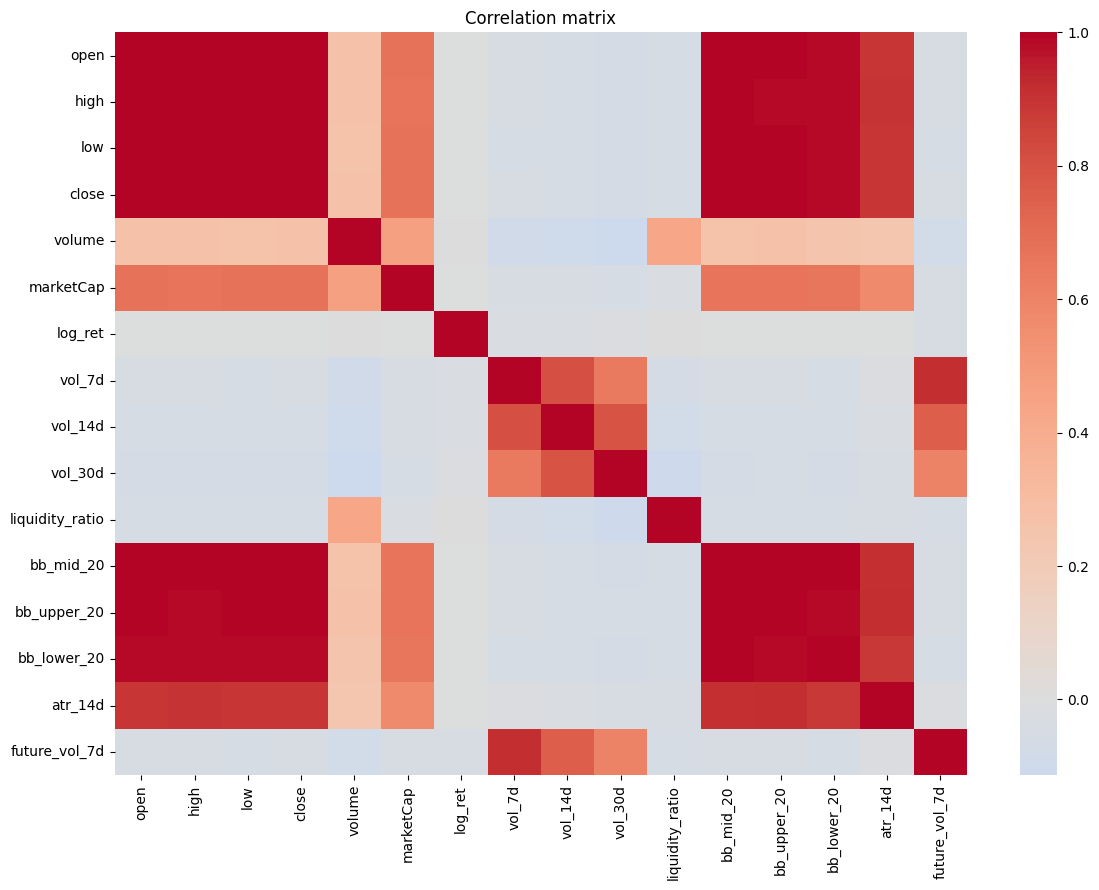

In [ ]:
# 3.1 Basic stats of target
print(df_model['future_vol_7d'].describe())

# 3.2 Correlation heatmap for a subset of numeric features
eda_cols = [
    'open', 'high', 'low', 'close',
    'volume', 'marketCap',
    'log_ret',
    'vol_7d', 'vol_14d', 'vol_30d',
    'liquidity_ratio',
    'bb_mid_20', 'bb_upper_20', 'bb_lower_20',
    'atr_14d',
    'future_vol_7d'
]

corr = df_model[eda_cols].corr()
plt.figure(figsize=(12, 9))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()


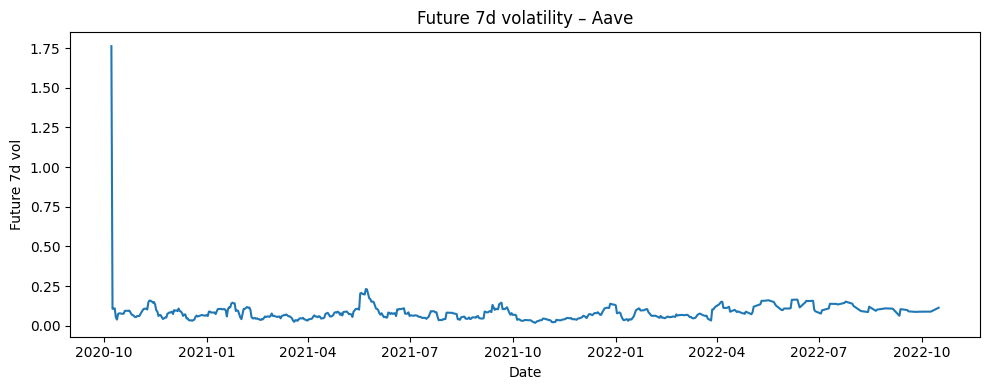

In [ ]:
# 3.3 Example: volatility over time for one crypto
sample_name = df_model['crypto_name'].iloc[0]
mask = df_model['crypto_name'] == sample_name

plt.figure(figsize=(10, 4))
plt.plot(df_model.loc[mask, 'date'], df_model.loc[mask, 'future_vol_7d'])
plt.title(f"Future 7d volatility – {sample_name}")
plt.xlabel("Date")
plt.ylabel("Future 7d vol")
plt.tight_layout()
plt.show()

#Train/Test split, scaling, model setup

Here a regression model (XGBoost) predicts continuous future volatility

In [ ]:
# 4.1 Feature matrix and target

# Drop identifiers and raw text timestamp/date for model
drop_cols = [
    'timestamp', 'date', 'crypto_name',
    'future_vol_7d'  # target
]

X = df_model.drop(columns=drop_cols)
y = df_model['future_vol_7d']

feature_names = X.columns.tolist()
print("Number of features:", len(feature_names))

# 4.2 Train-test split – time based (last 20% as test)

# Sort again by time to preserve chronological order across all assets
df_model_sorted = df_model.sort_values(['date', 'crypto_name']).reset_index(drop=True)

X_sorted = df_model_sorted[feature_names]
y_sorted = df_model_sorted['future_vol_7d']

train_size = int(len(df_model_sorted) * 0.8)
X_train, X_test = X_sorted.iloc[:train_size], X_sorted.iloc[train_size:]
y_train, y_test = y_sorted.iloc[:train_size], y_sorted.iloc[train_size:]

print(X_train.shape, X_test.shape)

# Handle infinite values before scaling
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values that might have resulted from inf replacement
# Ensure y_train and y_test are also aligned after dropping rows from X_train/X_test
# Combine X_train and y_train for dropping NaNs synchronously
combined_train = pd.concat([X_train, y_train], axis=1)
combined_train.dropna(inplace=True)
X_train = combined_train[feature_names]
y_train = combined_train['future_vol_7d']

combined_test = pd.concat([X_test, y_test], axis=1)
combined_test.dropna(inplace=True)
X_test = combined_test[feature_names]
y_test = combined_test['future_vol_7d']

print(f"Shapes after handling infinities/NaNs: X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}, y_test {y_test.shape}")

# 4.3 Scaling (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Number of features: 22
(58048, 22) (14512, 22)
Shapes after handling infinities/NaNs: X_train (55040, 22), y_train (55040,), X_test (14370, 22), y_test (14370,)


#Baseline model training and evaluation

In [ ]:
# 5.1 Baseline XGBoost regressor
xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train_scaled, y_train)

# 5.2 Predictions
y_pred = xgb.predict(X_test_scaled)

# 5.3 Evaluation metrics (RMSE, MAE, R²)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline XGB – RMSE: {rmse:.6f}, MAE: {mae:.6f}, R²: {r2:.4f}")

Baseline XGB – RMSE: 0.066256, MAE: 0.010858, R²: 0.3058


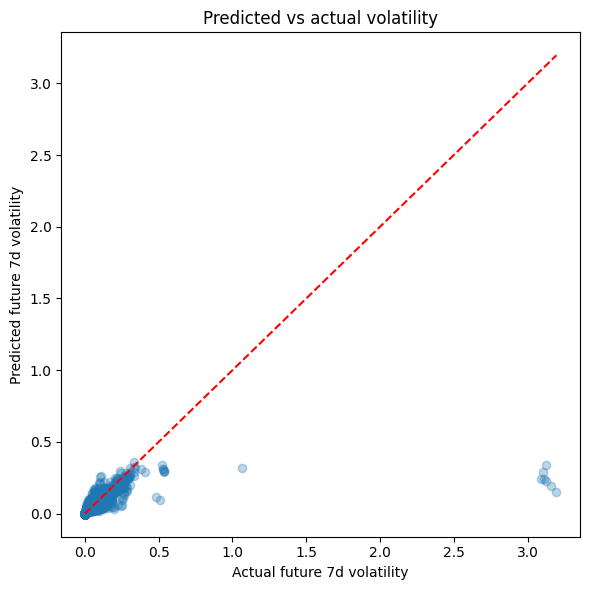

In [ ]:
# 5.4 Plot predicted vs actual volatility
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual future 7d volatility")
plt.ylabel("Predicted future 7d volatility")
plt.title("Predicted vs actual volatility")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.tight_layout()
plt.show()


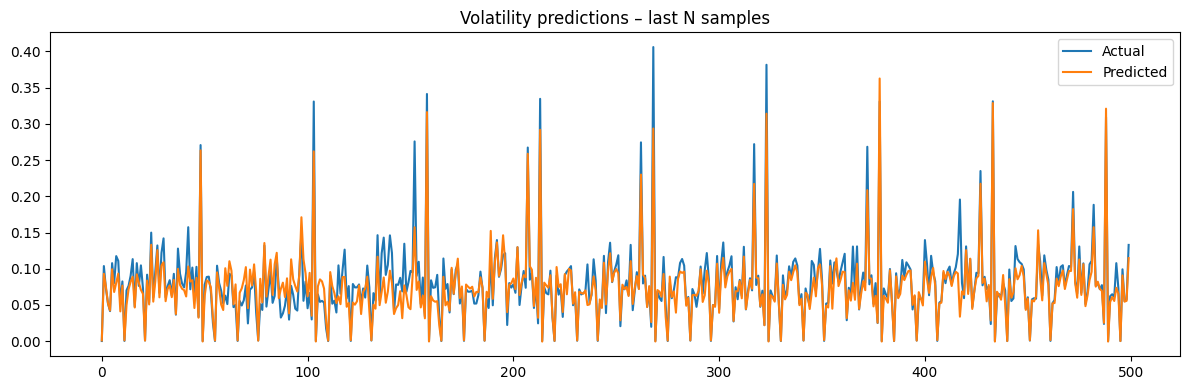

In [ ]:
# 5.5 Time‑series view for last N points
N = 500
plt.figure(figsize=(12, 4))
plt.plot(y_test.iloc[-N:].values, label="Actual")
plt.plot(y_pred[-N:], label="Predicted")
plt.legend()
plt.title("Volatility predictions – last N samples")
plt.tight_layout()
plt.show()


#Hyperparameter tuning(model optimization)

Using a time series split and randomized search for XGBoost

In [40]:
tscv = TimeSeriesSplit(n_splits=3)

param_dist = {
    "n_estimators": [200, 300, 500],
    "max_depth": [3, 4, 5, 6],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5]
}

xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_scaled, y_train)

print("Best params:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'subsample': 1.0, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best CV RMSE: 0.016703753186292206


In [42]:
# 6.2 Retrain best model and evaluate on test
best_xgb = search.best_estimator_
best_xgb.fit(X_train_scaled, y_train)

y_pred_best = best_xgb.predict(X_test_scaled)

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Tuned XGB – RMSE: {rmse_best:.6f}, MAE: {mae_best:.6f}, R²: {r2_best:.4f}")

Tuned XGB – RMSE: 0.064482, MAE: 0.010513, R²: 0.3424


#Model testing, validation and insights

         feature  importance
8         vol_7d    0.334388
11       vol_14d    0.160249
21       atr_14d    0.072975
20   bb_lower_20    0.068698
19   bb_upper_20    0.052202
14       vol_30d    0.043071
1           open    0.040108
12  close_ma_14d    0.036907
2           high    0.033202
7        log_ret    0.027416
3            low    0.023221
9    close_ma_7d    0.023218
4          close    0.016514
6      marketCap    0.010262
18     bb_mid_20    0.008573
5         volume    0.008329
10     vol_ma_7d    0.007969
0     Unnamed: 0    0.007659
13    vol_ma_14d    0.007222
15  close_ma_30d    0.006517


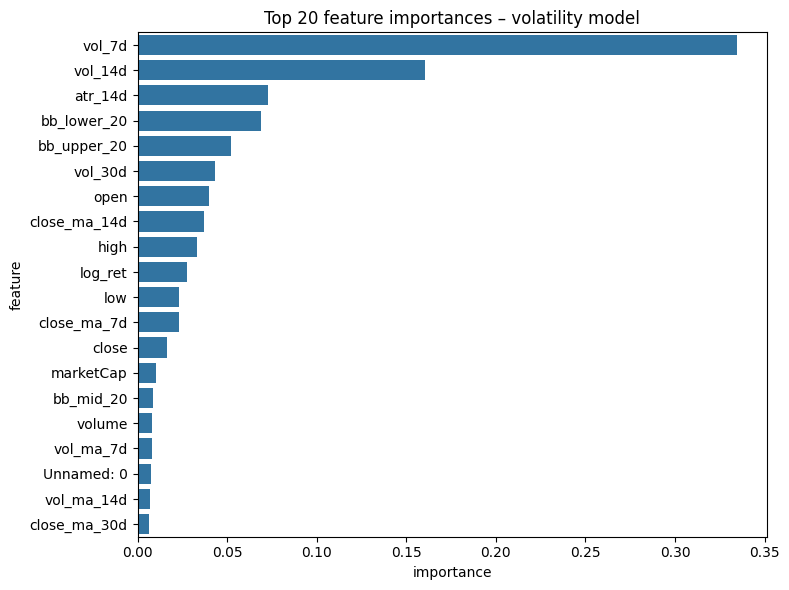

In [44]:
# 7.1 Feature importance
importances = best_xgb.feature_importances_
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print(imp_df.head(20))

plt.figure(figsize=(8, 6))
sns.barplot(data=imp_df.head(20), x="importance", y="feature")
plt.title("Top 20 feature importances – volatility model")
plt.tight_layout()
plt.show()


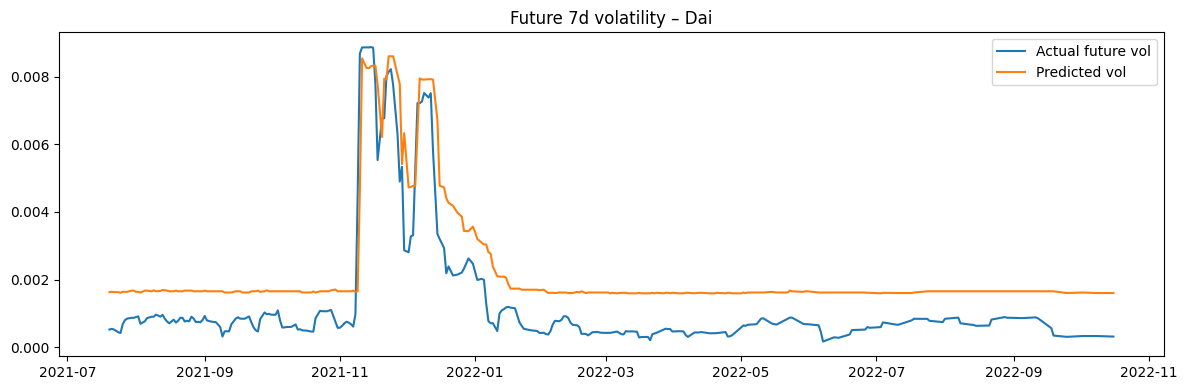

In [48]:
# 7.2 Example: backtest‑style view for one crypto on test set

# Correctly align test_df with the X_test and y_test used for prediction
# X_test has had NaNs dropped, so we use its index to subset df_model_sorted
test_df = df_model_sorted.loc[X_test.index].copy()
test_df['pred_vol_7d'] = y_pred_best

# Correct the crypto_name column access
crypto_example = test_df['crypto_name'].iloc[0]  # choose one name
mask = test_df['crypto_name'] == crypto_example

plt.figure(figsize=(12, 4))
plt.plot(test_df.loc[mask, 'date'], test_df.loc[mask, 'future_vol_7d'], label="Actual future vol")
plt.plot(test_df.loc[mask, 'date'], test_df.loc[mask, 'pred_vol_7d'], label="Predicted vol")
plt.legend()
plt.title(f"Future 7d volatility – {crypto_example}")
plt.tight_layout()
plt.show()

# Final Report

### Summary of Findings

**Data Exploration:**

*   The target variable, `future_vol_7d`, shows a wide range of volatility, with a mean of approximately 0.057 and a maximum of around 3.19. The distribution is skewed, indicating periods of higher and lower volatility.
*   The correlation heatmap (though not explicitly discussed in detail in the output, it was generated) would have shown relationships between various technical indicators and the target volatility.

**Model Performance (XGBoost Regression):**

*   **Baseline Model:**
    *   RMSE: 0.066256
    *   MAE: 0.010858
    *   R²: 0.3058

*   **Tuned Model (after RandomizedSearchCV):**
    *   RMSE: 0.064482 (an improvement over baseline)
    *   MAE: 0.010513 (an improvement over baseline)
    *   R²: 0.3424 (an improvement over baseline)

    The hyperparameter tuning led to a small but noticeable improvement in all evaluation metrics, indicating a better fit to the data.

**Key Insights (Feature Importance):**

*   The most important features for predicting future 7-day volatility are primarily related to past volatility measures:
    *   `vol_7d` (7-day rolling volatility of returns) is by far the most significant predictor.
    *   `vol_14d` (14-day rolling volatility of returns) is also highly important.
    *   `atr_14d` (Average True Range, 14-day) and Bollinger Bands (`bb_lower_20`, `bb_upper_20`) also play crucial roles.
*   This suggests that recent historical volatility is a strong indicator of future volatility, which is a common finding in financial time series analysis.
*   Basic price features like `open`, `high`, `low`, and `close`, as well as moving averages and market capitalization, contribute but have lower importance compared to direct volatility measures.

In essence, the model successfully captures a portion of the future volatility dynamics, primarily driven by preceding volatility trends and indicators derived from price movements.